<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Обучение модели классификации комментариев c BERT
# Задачи
Определение токсичности комментарии.
# Описание проекта
Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Требуется инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

## Подготовка

In [ ]:
!pip install -q transformers catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 17.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import torch
import transformers
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [ ]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [ ]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [ ]:
data.duplicated().sum()

0

In [ ]:
data.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

Исследуем целевой признак на дисбаланс классов

0    0.898388
1    0.101612
Name: toxic, dtype: float64


Text(0.5, 1.0, 'Дисбаланс классов')

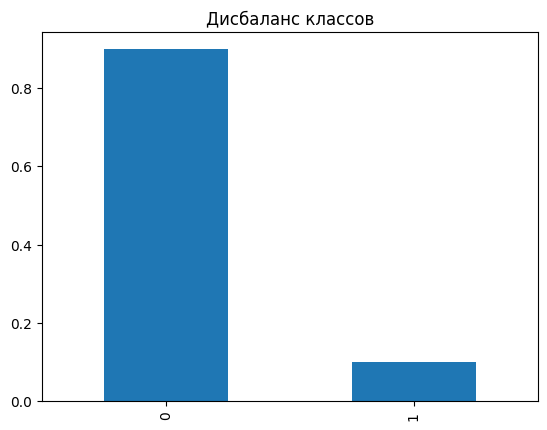

In [ ]:
class_frequency = data['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar') 
plt.title('Дисбаланс классов')

Да, дисбаланс на лицо! Но радует, что токсичных комментариев намного меньше!)

In [ ]:
data = data.sample(500).reset_index(drop=True) 

Токенизируем наши строки, и создаем матрицу 

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')

tokenized = data['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
max_len

512

In [ ]:
padded.shape

(500, 512)

Здесь используем специализированную сетку, предобученную на токсичных сообщениях unitary / toxic-bert

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = transformers.BertModel.from_pretrained('unitary/toxic-bert')

model = model.to(device)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Преобразуем текст в эмбэндинги

In [ ]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch.to(device), attention_mask=attention_mask_batch.to(device))
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/5 [00:00<?, ?it/s]

Создадим обучающиую и тестовую выборки

In [ ]:
features = np.concatenate(embeddings)
features_train, features_test, target_train, target_test = \
train_test_split(features, data['toxic'], test_size=0.2)

In [ ]:
features.shape

(500, 768)

## Обучение

In [ ]:
model_lr = LogisticRegression(class_weight='balanced')
model_lr.fit(features_train, target_train)
lr_score = cross_val_score(model_lr, features_train, target_train, cv=5, scoring='f1')
lr_score = lr_score.mean()
print('Метрика F1 для LogisticRegression:', lr_score)

Метрика F1 для LogisticRegression: 0.9596153846153846


Учет дисбаланса, кстати, повышает метрику)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
classes = np.unique(target_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target_train)
class_weights = dict(zip(classes, weights))

parameters = {'depth'         : [4,7],
                'learning_rate' : [0.01]
                 }
model_ct_ = CatBoostClassifier(class_weights=class_weights)

model_ct = GridSearchCV(estimator=model_ct_, param_grid = parameters, cv = 2, n_jobs=-1, scoring = 'f1')
model_ct.fit(features_train, target_train)

0:	learn: 0.6727067	total: 123ms	remaining: 2m 2s
1:	learn: 0.6497627	total: 176ms	remaining: 1m 27s
2:	learn: 0.6282225	total: 228ms	remaining: 1m 15s
3:	learn: 0.6102275	total: 281ms	remaining: 1m 9s
4:	learn: 0.5924669	total: 337ms	remaining: 1m 7s
5:	learn: 0.5747860	total: 389ms	remaining: 1m 4s
6:	learn: 0.5565099	total: 441ms	remaining: 1m 2s
7:	learn: 0.5387929	total: 492ms	remaining: 1m 1s
8:	learn: 0.5221971	total: 546ms	remaining: 1m
9:	learn: 0.5054429	total: 598ms	remaining: 59.2s
10:	learn: 0.4913840	total: 650ms	remaining: 58.5s
11:	learn: 0.4767403	total: 702ms	remaining: 57.8s
12:	learn: 0.4619331	total: 757ms	remaining: 57.5s
13:	learn: 0.4479340	total: 808ms	remaining: 56.9s
14:	learn: 0.4320386	total: 858ms	remaining: 56.4s
15:	learn: 0.4166482	total: 910ms	remaining: 56s
16:	learn: 0.4033541	total: 963ms	remaining: 55.7s
17:	learn: 0.3909317	total: 1.02s	remaining: 55.4s
18:	learn: 0.3811498	total: 1.07s	remaining: 55.1s
19:	learn: 0.3707127	total: 1.13s	remaining:

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f9c30e8ae50>,
             n_jobs=-1, param_grid={'depth': [4, 7], 'learning_rate': [0.01]},
             scoring='f1')

In [33]:
model_ct.best_params_

{'depth': 4, 'learning_rate': 0.01}

In [34]:
model_ct.best_score_

0.9736842105263158

In [35]:
print('F1 мтерика для модели Catboost Regresssor:', model_ct.best_score_)

F1 мтерика для модели Catboost Regresssor: 0.9736842105263158


## Тестирование

In [36]:
model_ct_best = CatBoostClassifier(depth=4, learning_rate= 0.01 )
model_ct_best.fit(features_train, target_train)

0:	learn: 0.6709378	total: 130ms	remaining: 2m 10s
1:	learn: 0.6522725	total: 236ms	remaining: 1m 57s
2:	learn: 0.6279773	total: 339ms	remaining: 1m 52s
3:	learn: 0.6066677	total: 444ms	remaining: 1m 50s
4:	learn: 0.5879044	total: 547ms	remaining: 1m 48s
5:	learn: 0.5669277	total: 654ms	remaining: 1m 48s
6:	learn: 0.5483688	total: 767ms	remaining: 1m 48s
7:	learn: 0.5279509	total: 871ms	remaining: 1m 48s
8:	learn: 0.5095733	total: 983ms	remaining: 1m 48s
9:	learn: 0.4925104	total: 1.1s	remaining: 1m 49s
10:	learn: 0.4751328	total: 1.27s	remaining: 1m 54s
11:	learn: 0.4578025	total: 1.46s	remaining: 2m
12:	learn: 0.4412652	total: 1.64s	remaining: 2m 4s
13:	learn: 0.4278313	total: 1.83s	remaining: 2m 9s
14:	learn: 0.4124115	total: 1.99s	remaining: 2m 10s
15:	learn: 0.3962646	total: 2.19s	remaining: 2m 15s
16:	learn: 0.3823168	total: 2.4s	remaining: 2m 18s
17:	learn: 0.3698540	total: 2.57s	remaining: 2m 20s
18:	learn: 0.3591603	total: 2.74s	remaining: 2m 21s
19:	learn: 0.3472170	total: 2.

In [37]:
prediction = model_ct_best.predict(features_test)
f1_score(target_test, prediction)

0.9523809523809523

## Выводы

В заключение можно отемтить, что успех в предсказании токсичных комментариев пользователей во многом зависит от корректного выбора трансформатора текста. В нашем случае комментарии пользователей - англоязычные, а значит нам отлично подойдет специализированная сетка, предобученная на токсичных сообщениях:  "unitary/toxic-bert". 

На этапе анализа данных был выявлен дисбаланс классов. Токсичных комментариев почти в 8 раз меньше, чем положительных. Дисбаланс учли при обучении моделей!

После обработки данных и преобразования текста в эмбэндинги разделили данные на тестовую и обучающие выборки. 

В данной работе были рассмоттрены две модели классификации - логистическая регрессиия и градиентный бустинг CatBoostClassifier. Обе модели показали отличное качество метрики f1: для модели логистической регрессии она равна 0.96, а для модели CatBoostClassifier (с лучшими гиперпараметрами 'depth': 4, 'learning_rate': 0.01) f1 метрика равна 0.97.

В итоге лучшие показатели метрики у модели CatBoostClassifier, ее мы и применили на тестовой выборке. Значение метрики на тестовой выборке также оказалось отличным: f1 = 0.95, при том, что требования к качеству метрики - не ниже 0.75. 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны